# 1. Introduction
tbd

motivation

previous state of the art

# 2. Focault test data reduction

This document will describe step by step the process of extracting the surface profile of a telescope mirror from Foucault or Wire test data.

## 2.1. Obtaining the mirror profile

Before jumping into the simulation, we need to find the model that will obtain the mirror surface profile from test data.
After that, we will perform a simulation with real world data.

### 2.1.1. Deriving the equations

First we need to derive the set of equations that will alow to obtaing the mirror surface profile from test data.

For a generic concave mirror surface, the Foucault or Wire tests will show for each mirror radius the equivalent radius of curvature it has. This can be interpreted as finding a succession of spherical surfaces that approximate the existing mirror surface (dashed curve in figure). Obviously that for a completely spherical mirror surface, there is exactly one sphere that matches the whole surface.

<img src="figures/diagram_1.svg" width="800"/>

The result of these tests is a set of data pairs consisting of mirror diameter $x$ (independent variable) and its respective radius of curvature $f(x)$ (dependent variable).

To help formulate the equations that model these tests, we can instead think of vectors $G(x)$ and $F(x)$ representing surface height respective to its center and radius of curvature respectively:

\begin{align}
G(x) = \langle x, g(x) \rangle \\
F(x) = \langle 0, f(x) \rangle
\end{align}

Subtracting the two vectors gives:

\begin{equation}
F(x) - G(x) = \langle 0 - x, f(x)-g(x) \rangle = \langle -x, f(x) - g(x) \rangle
\end{equation}

If we then represent the tangent vector to mirror surface at $G(x)$:

\begin{equation}
T(x) = \frac{G'(x)}{|G'(x)|} = \langle\frac{1}{|G'(x)|}, \frac{z'(x)}{|G'(x)|}\rangle
\end{equation}

Then it follows that:

\begin{align}
T(x) \cdot (F(x) - G(x)) = 0 \\
\left( - \frac{x}{|G'(x)|} + (f(x) - g(x))\frac{g'(x)}{|G'(x)|} \right) = 0\\
(f(x) - g(x))g'(x) = x
\end{align}

This results in the following differential equation:

\begin{equation}
g'(x) = \frac{x}{f(x) - g(x)}
\end{equation}

Knowing the data pairs $x$ and $f(x)$, we can integrate the equation above and get the mirror surface profile.

### 2.1.2. Finding a solution

Now in order to ... tbd Runge Kutta

### 2.1.3. Real world example

The real world collected data that will be used in this exercise is stored in a JSON file.

First we need to read the test data from the JSON file.

In [11]:
import json

with open('mirror_measurements_database.json', "r") as data_base_file:
    data_base = json.load(data_base_file)
    data_base_file.close()

diameter = data_base['diameter']
radius_of_curvature = data_base['radius_of_curvature_measurement']['radius_of_curvature']
measurements = sorted(data_base['measurements'], key=lambda m: m['optical_axis_offset'])

For convenience and to allow later use of the SciPy mathematical functions, we will first transform the data into Numpy arrays.

In [12]:
import pandas

measurements_data_frame = pandas.DataFrame(measurements)

display(measurements_data_frame) # Module display is part of library IPython

measurements_data_frame = measurements_data_frame.iloc[:,:2] # Remove the column containing the Foucault image captures

measurements_matrix = measurements_data_frame.to_numpy()
x = measurements_matrix[:, 1]
f = measurements_matrix[:, 0]

,optical_axis_offset,mirror_radius,foucaultgram
0,0.50,43.08,na.jpg
1,0.60,47.55,na.jpg
2,0.70,51.57,na.jpg
3,0.80,55.37,na.jpg
4,0.90,61.65,na.jpg
5,1.00,64.06,na.jpg
6,1.10,67.20,na.jpg
7,1.20,69.21,na.jpg
8,1.30,72.82,na.jpg
9,1.40,74.63,na.jpg


kjhkjhkh

In [13]:
import numpy
from scipy import interpolate

interpolate_f = interpolate.interp1d(x, f, kind="cubic")

num_samples = int((x[-1] - x[0])*2) # Generate 1 sample per 0.5mm increments 

x_e = numpy.linspace(x[0], x[-1], num=num_samples)
f_e = interpolate_f(x_e)

kjhkhkjh

<IPython.core.display.Javascript object>


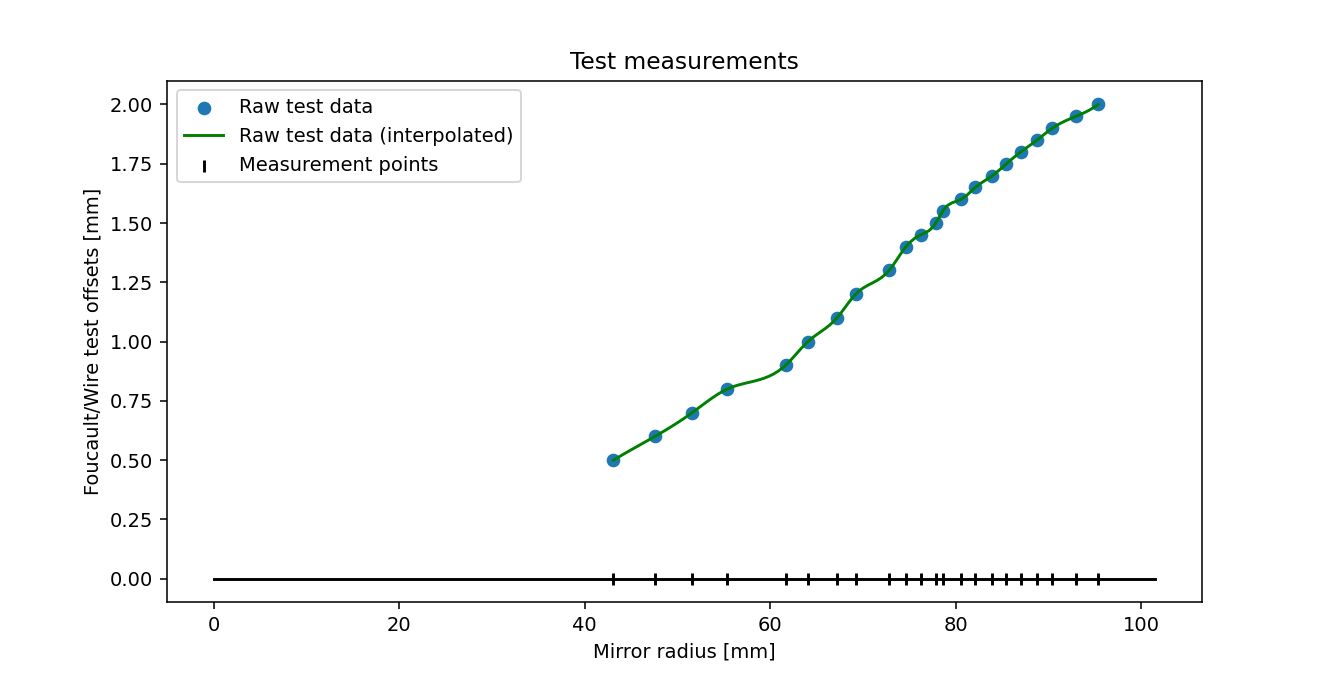

In [15]:
%matplotlib notebook
from matplotlib import pyplot

pyplot.title('Test measurements')
pyplot.scatter(x, f, label="Raw test data")
pyplot.plot(x_e, f_e, "g-", label="Raw test data (interpolated)")
pyplot.plot([0.0, diameter/2], [0.0, 0.0], "k")
pyplot.scatter(x, numpy.zeros(x.size), c="k", marker="|", label="Measurement points")
pyplot.xlabel('Mirror radius [mm]')
pyplot.ylabel('Foucault/Wire test offsets [mm]')
pyplot.legend()
pyplot.show()

In [16]:
from numba import jit

@jit(nopython=True)
def mirror_slope_ode_generic(x, f, g):
    dg = numpy.divide(x, numpy.subtract(f, g))
    return dg

def mirror_slope_ode(x, g):
    f_t = radius_of_curvature + interpolate_f(x)
    dg = mirror_slope_ode_generic(x, f_t, g)
    return dg

In [17]:
from scipy.integrate import solve_ivp

ode_solution = solve_ivp(fun=mirror_slope_ode,
                         t_span=[x_e[0], x_e[-1]],
                         y0=[0.0],
                         method="RK45",
                         t_eval=x_e,
                         vectorized=True,
                         dense_output=True)

g = numpy.reshape(ode_solution.y, (-1))

print(ode_solution.message)

The solver successfully reached the end of the integration interval.


fdgfdfg

<IPython.core.display.Javascript object>


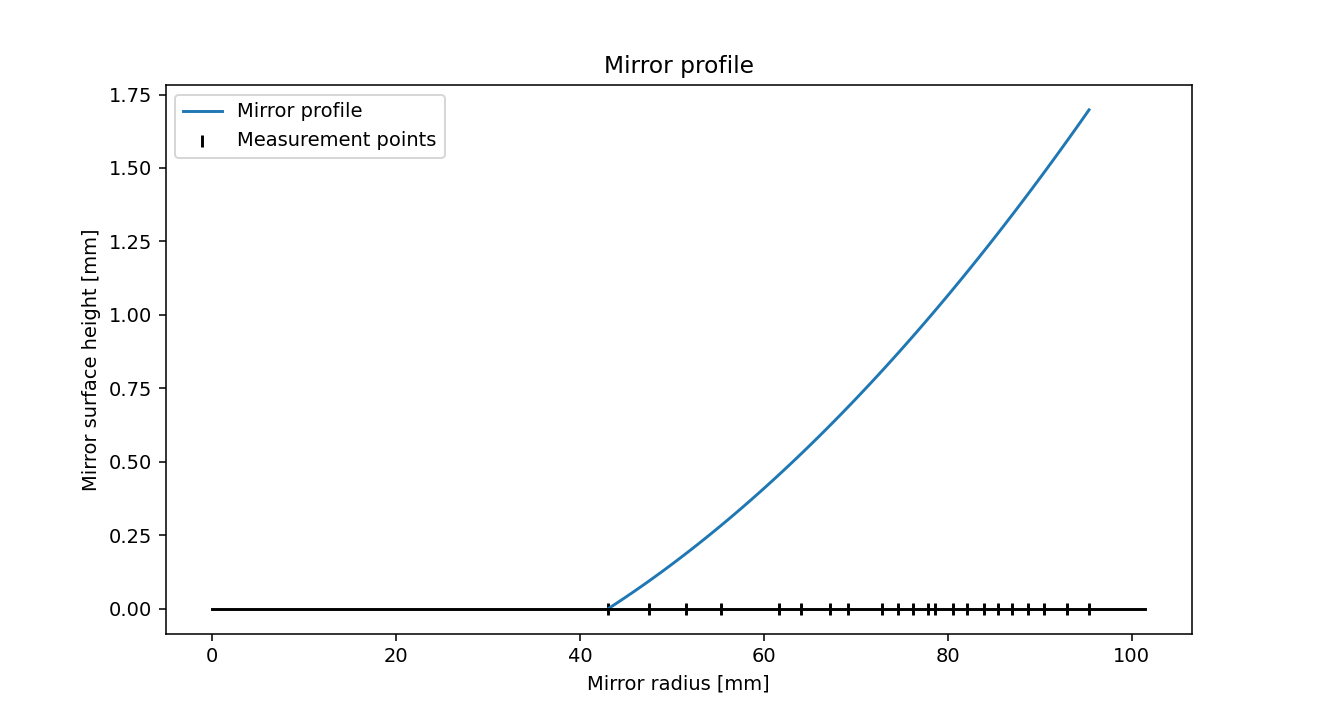

In [18]:
%matplotlib notebook
pyplot.title('Mirror profile')
pyplot.plot(x_e, g, label="Mirror profile")
pyplot.plot([0.0, diameter/2], [0.0, 0.0], "k")
pyplot.scatter(x, numpy.zeros(x.size), c="k", marker="|", label="Measurement points")
pyplot.xlabel('Mirror radius [mm]')
pyplot.ylabel('Mirror surface height [mm]')
pyplot.legend()
pyplot.show()

## 2.2. Finding the best fit conic curve

In section 1.1, it was shown the relationship between test data and the mirror surface's profile.
From that, a set of real test data was processed to obtain the shape of a real mirror under test.

This section will in turn show how to characterize the quality of the mirror under test, and for that, curve fitting will be used.

The general idea will be to find how the mirror under test profile compares to the desired profile - this will be accomplished through curve fitting and profile error measurement.

As it may also be usefull to identify what generic conic best fits with the mirror profile, a generic best fit conic and error analysis will also be carried.

To meet the requirements described above, we need to model the profile of an ideal mirror. For that we can check the industry standard in the optics industry and use the following model for aspheric surfaces (profile) from ISO 10110 Part 12:

\begin{equation}
g^*(x) = \frac{\frac{x^2}{R}}{1 + \sqrt{1 - (1 + k) \left(\frac{x}{R}\right)^2 } } + d.
\end{equation}

On the equation above:

$g^*(x)$ represents the ideal conic section if we assume that the missor is a figure of revolution arround its optical $z$ axis,

$x$ (and $y$ not represented here) represents the dimention along the mirror radius $r$ axis,

$R$ represents the radius of curvature at vertex, meaning the radius of curvature of the shpere (or circle in our 1-D visualisation) that best fits the central zone of the mirror,

$k$ is the conic constant (sphere: $k = 0$, paraboloid: $k=-1$, ...),

an $d$ represents an offset on the $z$ axis, i.e., if the center of curvature of the best fit profile doesn't touch the $x$ axis, it's offset is non-zero and has value $d$.

As stated initially, the purpose of this section will be to find the best fit curve, in other words, we need to find the set of parameters $R$, $k$ and $d$ that minimize the error between the ideal and measure mirror profile. For that we will use as the error measure the Root Mean Square Error (RMSE):

\begin{aligned}
RMSE = \sqrt{\frac{1}{\pi{r}^2} \int_{0}^{r} e(x)^2 \, 2\pi x \,dx}
\end{aligned}

where $e(x) = g^{*}(x)-g(x)$, is the error between the ideal and measured profiles.

Because we are assuming that the mirror under measurement is a perfect figure of revolution, and measurements taken are one dimensional only along the radius $x$, we are weighing each error point $e(x)$ with the mirror surface area increment it represents ($2\pi x \,dx$). The intuitive interpretation for this, is that the further the readings move from the center, the larger is the mirror area they represent and more impact on the overall error.

### 2.2.1. Deriving the equations

From the discussion above, it follows that:

\begin{aligned}
RMSE^2 & = \frac{1}{\pi{r}^2} \int_{0}^{r} (g^{*}(x)-g(x))^2 \, 2\pi x \,dx \\
& = \frac{2}{r^2} \int_{0}^{r} (g^{*}(x)-g(x))^2 \, x \,dx
\end{aligned}

tbd aproximate cost function

<img src="figures/diagram_3.svg" width="300"/>

\begin{aligned}
RMSE^2 & \approx \frac{2}{r^2} \sum_{n=1}^{N} \left[ \left(g^{*}(x_n)-g(x_n)\right)^2 \int_{\frac{x_{n}+x_{n-1}}{2}}^{\frac{x_{n+1}+x_{n}}{2}} x \,dx \right] \\
& = \frac{2}{r^2} \sum_{n=1}^{N} \left[ \left(g^{*}(x_n)-g(x_n)\right)^2 \left(\frac{x^2}{2}\Big|_{\frac{x_{n}+x_{n-1}}{2}}^{\frac{x_{n+1}+x_{n}}{2}}\right)\right] \\
& = \frac{1}{r^2} \sum_{n=1}^{N} \left[ \left(g^{*}(x_n)-g(x_n)\right)^2 \left( \left( \frac{x_{n+1} + x_{n}}{2} \right)^2 - \left( \frac{x_{n} + x_{n-1}}{2} \right)^2 \right) \right] \\
& = \frac{1}{4r^2} \sum_{n=1}^{N} \left[ \left(g^{*}(x_n)-g(x_n)\right)^2 \left(x_{n+1}^2 + 2x_{n}(x_{n+1}-x_{n-1}) - x_{n-1}^2\right) \right]
\end{aligned}

residuals...

\begin{equation}
RMSE^2 = \frac{1}{4r^2} \sum_{n=1}^{N} r_n^2
\end{equation}

with

\begin{equation}
r_n = \left(g^{*}(x_n)-g(x_n)\right) \sqrt{ x_{n+1}^2 + 2x_{n}(x_{n+1}-x_{n-1}) - x_{n-1}^2 }
\end{equation}


jacobian



### 2.2.2. Best fit conic to real data 

tbbd

In [23]:
@jit(nopython=True)
def aspheric_profile_function(x, k, R, d):
    num = numpy.power(x, 2)/R
    den = 1 + numpy.sqrt(1 - ((1 + k) * numpy.power(x, 2))/(R * R))
    gp = numpy.divide(num, den) + d

    return gp

@jit(nopython=True)
def aspheric_profile_jacobian(x, k, R, d):
    sample_number = x.size

    common = numpy.sqrt(1 - ((1 + k) * numpy.power(x, 2))/(R * R))

    part_div_d = numpy.ones(sample_number) # Partial derivative on d

    num = numpy.power(x, 4)
    den = 2 * R * R * R * numpy.multiply(common, numpy.power(common + 1, 2))

    part_div_k = numpy.divide(num, den) # Partial derivative on k

    num = numpy.negative(numpy.power(x, 2))
    den = R * R * numpy.multiply(common, common + 1)

    part_div_R = numpy.divide(num, den) # Partial derivative on R
    
    jacobian_vector = numpy.vstack((part_div_k, part_div_R, part_div_d))
    jacobian_vector = numpy.transpose(jacobian_vector)

    return jacobian_vector

tbd

In [24]:
@jit(nopython=True)
def residual_function(params, x, g):
    k = params[0]; R = params[1]; d = params[2]
    
    residual = numpy.subtract(aspheric_profile_function(x, k, R, d), g) # difference part of the residual equation r_n
        
    xnm = numpy.roll(x, 1); xnm[0] = x[0] # x_(n - 1)
    xn = x # x_n
    xnp = numpy.roll(x, -1); xnp[-1] = x[-1] # x_(n + 1)
    
    weight_1 = numpy.power(xnp, 2)
    weight_2 = 2 * numpy.multiply(xn, numpy.subtract(xnp, xnm))
    weight_3 = numpy.power(xnm, 2)
    weight = numpy.sqrt(numpy.add(weight_1, numpy.subtract(weight_2, weight_3))) # weight part of the residual equation r_n
    
    res = numpy.multiply(residual, weight)

    return res

@jit(nopython=True)
def residual_jacobian(params, x, g):
    k = params[0]; R = params[1]; d = params[2]
    
    xnm = numpy.roll(x, 1); xnm[0] = x[0] # x_(n - 1)
    xn = x # x_n
    xnp = numpy.roll(x, -1); xnp[-1] = x[-1] # x_(n + 1)
    
    weight_1 = numpy.power(xnp, 2)
    weight_2 = 2 * numpy.multiply(xn, numpy.subtract(xnp, xnm))
    weight_3 = numpy.power(xnm, 2)
    weight = numpy.sqrt(numpy.add(weight_1, numpy.subtract(weight_2, weight_3))) # weight part of the residual equation r_n
    
    jac_res = numpy.multiply(aspheric_profile_jacobian(x, k, R, d), weight)

    return jac_res

tbd

In [25]:
from scipy.optimize import least_squares

param_0 = numpy.array([-1.0, 2000.0, 0.1]) # k, R, d

least_squares_solution = least_squares(fun=residual_function,
                                       x0=param_0,
                                       jac=residual_jacobian,
                                       method="trf",
                                       loss="linear",
                                       args=(x_e, g))

print(least_squares_solution.message)

ValueError: unable to broadcast argument 1 to output array
File "C:\Users\nmsousa\AppData\Local\Temp/ipykernel_13064/476616799.py", line 1, 

### 2.2.3. Fit desired conic to real data 